# **Advanced Hyperparameter Optimization**

## Mục tiêu
- Sử dụng Optuna để tối ưu hyperparameters cho XGBoost, Random Forest, và Gradient Boosting
- Target: Test MAE < 1.0°C (hiện tại: 1.036°C)
- Sử dụng TimeSeriesSplit với 5-fold CV để đánh giá
- So sánh performance trước và sau optimization


In [173]:
import os
import sys
import random
import warnings
import pandas as pd
import numpy as np
import matplotlib
# matplotlib.use("Agg")  # uncomment nếu chạy headless/CI
import matplotlib.pyplot as plt

# Add project root to Python path
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.append(project_root)

# Core ML
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

# Boosting libs
from xgboost import XGBRegressor
from xgboost.callback import EarlyStopping
from lightgbm import LGBMRegressor
import lightgbm as lgb

# HPO
import optuna
from optuna.samplers import TPESampler
from optuna.pruners import MedianPruner

# Your utilities
from src.utils.performance_monitor import timed_mem_call
from src.utils.scores import _regression_scores 

# Reproducibility
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ.setdefault('OMP_NUM_THREADS', '4')
os.environ.setdefault('MKL_NUM_THREADS', '4')
os.environ.setdefault('NUMEXPR_NUM_THREADS', '4')
np.random.seed(SEED)
random.seed(SEED)
optuna.logging.set_verbosity(optuna.logging.WARNING)

# Warnings (có chủ đích)
warnings.filterwarnings("ignore", category=FutureWarning, module="sklearn")
warnings.filterwarnings("ignore", category=UserWarning, module="lightgbm")

print(f"Seed: {SEED}")
performance_stats = {}
print("Performance monitoring")

try:
    import sklearn, xgboost, lightgbm
    print(
        "Versions -> "
        f"sklearn: {sklearn.__version__} | "
        f"xgboost: {xgboost.__version__} | "
        f"lightgbm: {lightgbm.__version__} | "
        f"optuna: {optuna.__version__}"
    )
except Exception:
    pass


Seed: 42
Performance monitoring
Versions -> sklearn: 1.7.0 | xgboost: 3.0.5 | lightgbm: 4.6.0 | optuna: 4.5.0


# 1. Load Best Performance Dataset

In [72]:
print("Loading FE + DT dataset (best performing)")

def load_data(file_path):
    df = pd.read_csv(file_path)
    X = df.drop('target', axis=1)
    y = df['target']
    return X, y

print("Loading Training data")
(X_train, y_train), train_stats = timed_mem_call(load_data, '../dataset/processed/splits/fe_dt_train.csv', label="Load Train Data")
performance_stats['data_loading'] = {'train': train_stats}

print("Loading Validation data")
(X_val, y_val), val_stats = timed_mem_call(load_data, '../dataset/processed/splits/fe_dt_val.csv', label="Load Val Data")
performance_stats['data_loading']['val'] = val_stats

print("Loading Test data")
(X_test, y_test), test_stats = timed_mem_call(load_data, '../dataset/processed/splits/fe_dt_test.csv', label="Load Test Data")
performance_stats['data_loading']['test'] = test_stats

print(f"Train shape: {X_train.shape}")
print(f"Validation shape: {X_val.shape}")
print(f"Test shape: {X_test.shape}")
print(f"Features: {list(X_train.columns)}")

Loading FE + DT dataset (best performing)
Loading Training data
[Load Train Data] time=0.04s | Py-peak=26.4 MB | RSS(before/after/delta)=345.9/379.9/34.1 MB
Loading Validation data
[Load Val Data] time=0.01s | Py-peak=1.2 MB | RSS(before/after/delta)=379.9/386.0/6.1 MB
Loading Test data
[Load Test Data] time=0.01s | Py-peak=2.4 MB | RSS(before/after/delta)=386.0/388.2/2.2 MB
Train shape: (59058, 23)
Validation shape: (3150, 23)
Test shape: (6444, 23)
Features: ['humidity', 'precip', 'winddir', 'sealevelpressure', 'cloudcover', 'solarradiation', 'tempmin_C', 'temp_C', 'feelslikemax_C', 'feelslike_C', 'year', 'day_of_year', 'day_of_week', 'tempmax_C_lag1', 'tempmax_C_lag2', 'tempmax_C_lag3', 'tempmax_C_lag4', 'tempmax_C_rollmean7', 'tempmax_C_rollmean3', 'tempmax_C_rollstd7', 'month_sin', 'doy_sin', 'doy_cos']


# 2. Utility Function

In [ ]:
ES_ROUNDS = 100
ES_METRIC = "mae"

def time_series_cv_score_with_es(model_name, params, X, y, cv_splits=5, gap=7):
    """
    CV cho time series với early stopping cho XGB/LGB:
      - XGB 3.0.5: đặt eval_metric & early_stopping_rounds trong constructor; fit chỉ dùng eval_set
      - LGB: dùng callback early_stopping
      - RF/GB: không ES
    Trả về: mean_mae (float), median_best_iter (int or None)
    """
    tscv = TimeSeriesSplit(n_splits=cv_splits, gap=gap)
    maes = []
    best_iters = []

    for train_idx, val_idx in tscv.split(X):
        X_tr = X.iloc[train_idx]
        X_va = X.iloc[val_idx]
        y_tr = y.iloc[train_idx]
        y_va = y.iloc[val_idx]

        if model_name == 'xgb':
            mdl = XGBRegressor(
                **params,
                random_state=SEED, n_jobs=-1, verbosity=0,
                eval_metric=ES_METRIC,
                early_stopping_rounds=ES_ROUNDS
            )
            mdl.fit(
                X_tr, y_tr,
                eval_set=[(X_va, y_va)],
                verbose=False
            )
            y_hat = mdl.predict(X_va)
            best_iters.append(getattr(mdl, "best_iteration_", params.get("n_estimators", None)))

        elif model_name == 'lgb':
            from lightgbm import early_stopping
            mdl = LGBMRegressor(**params, random_state=SEED, n_jobs=-1, verbosity=-1)
            mdl.fit(
                X_tr, y_tr,
                eval_set=[(X_va, y_va)],
                eval_metric=ES_METRIC,
                callbacks=[early_stopping(ES_ROUNDS, verbose=False)]
            )
            y_hat = mdl.predict(X_va)
            best_iters.append(getattr(mdl, "best_iteration_", params.get("n_estimators", None)))

        elif model_name == 'rf':
            mdl = RandomForestRegressor(**params, random_state=SEED, n_jobs=-1)
            mdl.fit(X_tr, y_tr)
            y_hat = mdl.predict(X_va)

        elif model_name == 'gb':
            mdl = GradientBoostingRegressor(**params, random_state=SEED)
            mdl.fit(X_tr, y_tr)
            y_hat = mdl.predict(X_va)

        else:
            raise ValueError(f"Unknown model_name: {model_name}")

        mae, _, _ = _regression_scores(y_va, y_hat)
        maes.append(mae)

    mean_mae = float(np.mean(maes))
    median_best_iter = int(np.median([b for b in best_iters if b is not None])) if len(best_iters) > 0 else None
    return mean_mae, median_best_iter


# 3. XGBoost Hyperparameter Optimization

In [80]:
print("XGBOOST HYPERPARAMETER OPTIMIZATION (with ES in CV)")
def xgb_objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 200, 3000),
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.3, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 10.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 10.0),
    }
    mean_mae, _ = time_series_cv_score_with_es('xgb', params, X_train, y_train, cv_splits=5, gap=7)
    trial.set_user_attr("mean_mae", mean_mae)
    return mean_mae

xgb_study = optuna.create_study(
    direction='minimize',
    sampler=TPESampler(seed=SEED),
    pruner=MedianPruner(n_startup_trials=5, n_warmup_steps=10)
)
print("Starting XGBoost optimization (100 trials)")
xgb_optimization_result, xgb_opt_stats = timed_mem_call(
    xgb_study.optimize,
    xgb_objective,
    n_trials=100,
    show_progress_bar=True,
    label="XGBoost Optimization"
)
performance_stats['xgb_optimization'] = xgb_opt_stats

print("\nBest XGBoost parameters:")
for k, v in xgb_study.best_params.items():
    print(f"  {k}: {v}")
print(f"Best CV MAE: {xgb_study.best_value:.4f}°C")

# Lấy median best_iter cho best_params
xgb_cv_mean, xgb_cv_best_iter = time_series_cv_score_with_es('xgb', xgb_study.best_params, X_train, y_train, cv_splits=5, gap=7)
print(f"XGB median best_iteration_ from CV: {xgb_cv_best_iter}")

XGBOOST HYPERPARAMETER OPTIMIZATION (with ES in CV)
Starting XGBoost optimization (100 trials)


  0%|          | 0/100 [00:00<?, ?it/s]

[XGBoost Optimization] time=3789.75s | Py-peak=26.0 MB | RSS(before/after/delta)=387.0/1171.9/784.9 MB

Best XGBoost parameters:
  n_estimators: 1628
  learning_rate: 0.04334905444894986
  max_depth: 11
  min_child_weight: 5
  subsample: 0.890836080531072
  colsample_bytree: 0.7850552386169434
  reg_alpha: 0.293682708241164
  reg_lambda: 3.9216286532418927
Best CV MAE: 0.5137°C
XGB median best_iteration_ from CV: 1628


# 4. Random Forest Hyperparameter Optimization

In [81]:
print("RANDOM FOREST HYPERPARAMETER OPTIMIZATION")
def rf_objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 200, 1500),
        'max_depth': trial.suggest_int('max_depth', 5, 30),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', 0.3, 0.5, 0.7, 0.9]),
        'bootstrap': trial.suggest_categorical('bootstrap', [True, False]),
    }
    mean_mae, _ = time_series_cv_score_with_es('rf', params, X_train, y_train, cv_splits=5, gap=7)
    trial.set_user_attr("mean_mae", mean_mae)
    return mean_mae

rf_study = optuna.create_study(
    direction='minimize',
    sampler=TPESampler(seed=SEED),
    pruner=MedianPruner(n_startup_trials=5, n_warmup_steps=10)
)
print("Starting Random Forest optimization (50 trials)")
rf_optimization_result, rf_opt_stats = timed_mem_call(
    rf_study.optimize,
    rf_objective,
    n_trials=50,
    show_progress_bar=True,
    label="Random Forest Optimization"
)
performance_stats['rf_optimization'] = rf_opt_stats

print("\nBest Random Forest parameters:")
for k, v in rf_study.best_params.items():
    print(f"  {k}: {v}")
print(f"Best CV MAE: {rf_study.best_value:.4f}°C")

RANDOM FOREST HYPERPARAMETER OPTIMIZATION
Starting Random Forest optimization (50 trials)


  0%|          | 0/50 [00:00<?, ?it/s]

[Random Forest Optimization] time=4168.46s | Py-peak=40.1 MB | RSS(before/after/delta)=265.0/3108.8/2843.7 MB

Best Random Forest parameters:
  n_estimators: 1324
  max_depth: 24
  min_samples_split: 4
  min_samples_leaf: 1
  max_features: 0.5
  bootstrap: False
Best CV MAE: 0.5452°C


# 5. Gradient Boosting Hyperparameter Optimization

In [100]:
print("GRADIENT BOOSTING HYPERPARAMETER OPTIMIZATION")
def gb_objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 200, 2000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', 0.3, 0.5, 0.7, 0.9, None]),
    }
    mean_mae, _ = time_series_cv_score_with_es('gb', params, X_train, y_train, cv_splits=5, gap=7)
    trial.set_user_attr("mean_mae", mean_mae)
    return mean_mae

gb_study = optuna.create_study(
    direction='minimize',
    sampler=TPESampler(seed=SEED),
    pruner=MedianPruner(n_startup_trials=5, n_warmup_steps=10)
)
print("Starting Gradient Boosting optimization (50 trials)")
gb_optimization_result, gb_opt_stats = timed_mem_call(
    gb_study.optimize,
    gb_objective,
    n_trials=50,
    show_progress_bar=True,
    label="Gradient Boosting Optimization"
)
performance_stats['gb_optimization'] = gb_opt_stats

print("\nBest Gradient Boosting parameters:")
for k, v in gb_study.best_params.items():
    print(f"  {k}: {v}")
print(f"Best CV MAE: {gb_study.best_value:.4f}°C")

GRADIENT BOOSTING HYPERPARAMETER OPTIMIZATION
Starting Gradient Boosting optimization (50 trials)


  0%|          | 0/50 [00:00<?, ?it/s]

[Gradient Boosting Optimization] time=23840.21s | Py-peak=22.0 MB | RSS(before/after/delta)=392.4/622.6/230.3 MB

Best Gradient Boosting parameters:
  n_estimators: 1671
  learning_rate: 0.058821741627037
  max_depth: 10
  min_samples_split: 14
  min_samples_leaf: 6
  subsample: 0.9970093351594332
  max_features: log2
Best CV MAE: 0.5131°C


# 6. LightGBM Hyperparameter Optimization

In [111]:
print("LIGHTGBM HYPERPARAMETER OPTIMIZATION (with ES in CV)")
def lgb_objective(trial):
    max_depth = trial.suggest_int('max_depth', 3, 12)
    max_leaves = min(250, 2**max_depth - 1)
    
    # Ensure num_leaves range is valid: low <= high
    min_leaves = min(16, max_leaves)
    max_leaves_safe = max(min_leaves, max_leaves)
    
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 200, 3000),
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.3, log=True),
        'max_depth': max_depth,
        'num_leaves': trial.suggest_int('num_leaves', min_leaves, max_leaves_safe),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'min_gain_to_split': trial.suggest_float('min_gain_to_split', 0.0, 1.0),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 10.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 10.0),
    }
    mean_mae, _ = time_series_cv_score_with_es('lgb', params, X_train, y_train, cv_splits=5, gap=7)
    trial.set_user_attr("mean_mae", mean_mae)
    return mean_mae

lgb_study = optuna.create_study(
    direction='minimize',
    sampler=TPESampler(seed=SEED),
    pruner=MedianPruner(n_startup_trials=5, n_warmup_steps=10)
)
print("Starting LightGBM optimization (80 trials)")
lgb_optimization_result, lgb_opt_stats = timed_mem_call(
    lgb_study.optimize,
    lgb_objective,
    n_trials=80,
    show_progress_bar=True,
    label="LightGBM Optimization"
)
performance_stats['lgb_optimization'] = lgb_opt_stats

print("\nBest LightGBM parameters:")
for k, v in lgb_study.best_params.items():
    print(f"  {k}: {v}")
print(f"Best CV MAE: {lgb_study.best_value:.4f}°C")

LIGHTGBM HYPERPARAMETER OPTIMIZATION (with ES in CV)
Starting LightGBM optimization (80 trials)


  0%|          | 0/80 [00:00<?, ?it/s]

[LightGBM Optimization] time=3593.48s | Py-peak=112.3 MB | RSS(before/after/delta)=2932.9/1262.0/-1670.9 MB

Best LightGBM parameters:
  max_depth: 11
  n_estimators: 2077
  learning_rate: 0.15661229817109765
  num_leaves: 140
  min_child_samples: 5
  min_gain_to_split: 0.0002621123047130136
  subsample: 0.7569164312790067
  colsample_bytree: 0.91140091751664
  reg_alpha: 6.0984899970408835
  reg_lambda: 7.625658160608289
Best CV MAE: 0.5551°C


# 7. Model Selection Based on CV Results

In [112]:
print("MODEL SELECTION BASED ON CV RESULTS")

# Get best model from CV results
cv_results = {
    'XGBoost': xgb_study.best_value,
    'Random Forest': rf_study.best_value,
    'Gradient Boosting': gb_study.best_value,
    'LightGBM': lgb_study.best_value if hasattr(lgb_study, 'best_value') and lgb_study.best_value is not None else float('inf')
}


best_model_name = min(cv_results.keys(), key=lambda x: cv_results[x])
print(f"Best model based on CV MAE: {best_model_name} ({cv_results[best_model_name]:.4f}°C)")

print("\nCV Results Summary:")
for model, score in cv_results.items():
    print(f"  {model}: {score:.4f}°C")

MODEL SELECTION BASED ON CV RESULTS
Best model based on CV MAE: Gradient Boosting (0.5131°C)

CV Results Summary:
  XGBoost: 0.5137°C
  Random Forest: 0.5452°C
  Gradient Boosting: 0.5131°C
  LightGBM: 0.5551°C


# 8. Final Model Training and Evaluation

In [129]:
# Train Final Models for All Algorithms and Compare Test Performance
print("TRAINING FINAL MODELS FOR ALL ALGORITHMS")

# Combine train and validation for final model training
X_train_val = pd.concat([X_train, X_val], axis=0)
y_train_val = pd.concat([y_train, y_val], axis=0)

print(f"Training all final models on combined train+val data: {X_train_val.shape}")

# Define all models with their best parameters
final_models = {}

# 1. XGBoost Final Model
def train_xgb_final():
    model = XGBRegressor(**xgb_study.best_params, random_state=SEED, n_jobs=-1, verbosity=0)
    model.fit(X_train_val, y_train_val)
    return model

xgb_final, xgb_train_stats = timed_mem_call(train_xgb_final, label="XGBoost Final Training")
final_models['XGBoost'] = xgb_final
performance_stats['xgb_final_training'] = xgb_train_stats

# 2. Random Forest Final Model
def train_rf_final():
    model = RandomForestRegressor(**rf_study.best_params, random_state=SEED, n_jobs=-1)
    model.fit(X_train_val, y_train_val)
    return model

rf_final, rf_train_stats = timed_mem_call(train_rf_final, label="Random Forest Final Training")
final_models['Random Forest'] = rf_final
performance_stats['rf_final_training'] = rf_train_stats

# 3. Gradient Boosting Final Model
def train_gb_final():
    model = GradientBoostingRegressor(**gb_study.best_params, random_state=SEED)
    model.fit(X_train_val, y_train_val)
    return model

gb_final, gb_train_stats = timed_mem_call(train_gb_final, label="Gradient Boosting Final Training")
final_models['Gradient Boosting'] = gb_final
performance_stats['gb_final_training'] = gb_train_stats

# 4. LightGBM Final Model
def train_lgb_final():
    model = LGBMRegressor(**lgb_study.best_params, random_state=SEED, n_jobs=-1, verbosity=-1)
    model.fit(X_train_val, y_train_val)
    return model

lgb_final, lgb_train_stats = timed_mem_call(train_lgb_final, label="LightGBM Final Training")
final_models['LightGBM'] = lgb_final
performance_stats['lgb_final_training'] = lgb_train_stats

print(f"Models: {list(final_models.keys())}")


TRAINING FINAL MODELS FOR ALL ALGORITHMS
Training all final models on combined train+val data: (62208, 23)
[XGBoost Final Training] time=9.50s | Py-peak=0.3 MB | RSS(before/after/delta)=2583.1/3192.6/609.5 MB
[Random Forest Final Training] time=45.42s | Py-peak=17.3 MB | RSS(before/after/delta)=3212.9/2486.5/-726.4 MB
[Gradient Boosting Final Training] time=133.66s | Py-peak=10.7 MB | RSS(before/after/delta)=2502.5/2534.2/31.7 MB
[LightGBM Final Training] time=27.48s | Py-peak=29.1 MB | RSS(before/after/delta)=2541.8/2624.9/83.1 MB
Models: ['XGBoost', 'Random Forest', 'Gradient Boosting', 'LightGBM']


In [131]:
# Test All Final Models and Compare Performance
print("TESTING ALL FINAL MODELS")

# Test all models and collect results
all_test_results = {}

for model_name, model in final_models.items():
    print(f"\nTesting {model_name}")
    
    # Test predictions with performance monitoring
    def test_model():
        test_pred = model.predict(X_test)
        test_mae, test_rmse, test_r2 = _regression_scores(y_test, test_pred)
        return test_pred, test_mae, test_rmse, test_r2
    
    (test_pred, test_mae, test_rmse, test_r2), test_stats = timed_mem_call(
        test_model, 
        label=f"{model_name} Test Evaluation"
    )
    
    all_test_results[model_name] = {
        'test_mae': test_mae,
        'test_rmse': test_rmse,
        'test_r2': test_r2,
        'test_predictions': test_pred
    }
    
    performance_stats[f'{model_name.lower().replace(" ", "_")}_test'] = test_stats
    
    print(f"  Test MAE: {test_mae:.4f}°C")
    print(f"  Test RMSE: {test_rmse:.4f}°C")
    print(f"  Test R²: {test_r2:.4f}")

# Create comprehensive results DataFrame
results_comparison = pd.DataFrame({
    model: {
        'Test MAE': results['test_mae'],
        'Test RMSE': results['test_rmse'],
        'Test R²': results['test_r2']
    }
    for model, results in all_test_results.items()
}).T

display(results_comparison.round(4))
# Find best performing model on test set
best_test_model = results_comparison['Test MAE'].idxmin()
best_test_mae = results_comparison.loc[best_test_model, 'Test MAE']

print(f"\nBEST PERFORMING MODEL ON TEST SET:")
print(f"  Model: {best_test_model}")
print(f"  Test MAE: {best_test_mae:.4f}°C")


TESTING ALL FINAL MODELS

Testing XGBoost
[XGBoost Test Evaluation] time=0.05s | Py-peak=0.2 MB | RSS(before/after/delta)=4800.8/4800.8/0.0 MB
  Test MAE: 1.0000°C
  Test RMSE: 1.3047°C
  Test R²: 0.5937

Testing Random Forest
[Random Forest Test Evaluation] time=0.22s | Py-peak=2.0 MB | RSS(before/after/delta)=4800.8/4801.0/0.2 MB
  Test MAE: 0.9934°C
  Test RMSE: 1.2854°C
  Test R²: 0.6056

Testing Gradient Boosting
[Gradient Boosting Test Evaluation] time=0.19s | Py-peak=1.1 MB | RSS(before/after/delta)=4801.0/4801.6/0.7 MB
  Test MAE: 1.0135°C
  Test RMSE: 1.3310°C
  Test R²: 0.5771

Testing LightGBM
[LightGBM Test Evaluation] time=0.05s | Py-peak=0.2 MB | RSS(before/after/delta)=4801.6/4801.6/0.0 MB
  Test MAE: 1.0410°C
  Test RMSE: 1.3522°C
  Test R²: 0.5636


,Test MAE,Test RMSE,Test R²
XGBoost,1.0000,1.3047,0.5937
Random Forest,0.9934,1.2854,0.6056
Gradient Boosting,1.0135,1.3310,0.5771
LightGBM,1.0410,1.3522,0.5636



BEST PERFORMING MODEL ON TEST SET:
  Model: Random Forest
  Test MAE: 0.9934°C


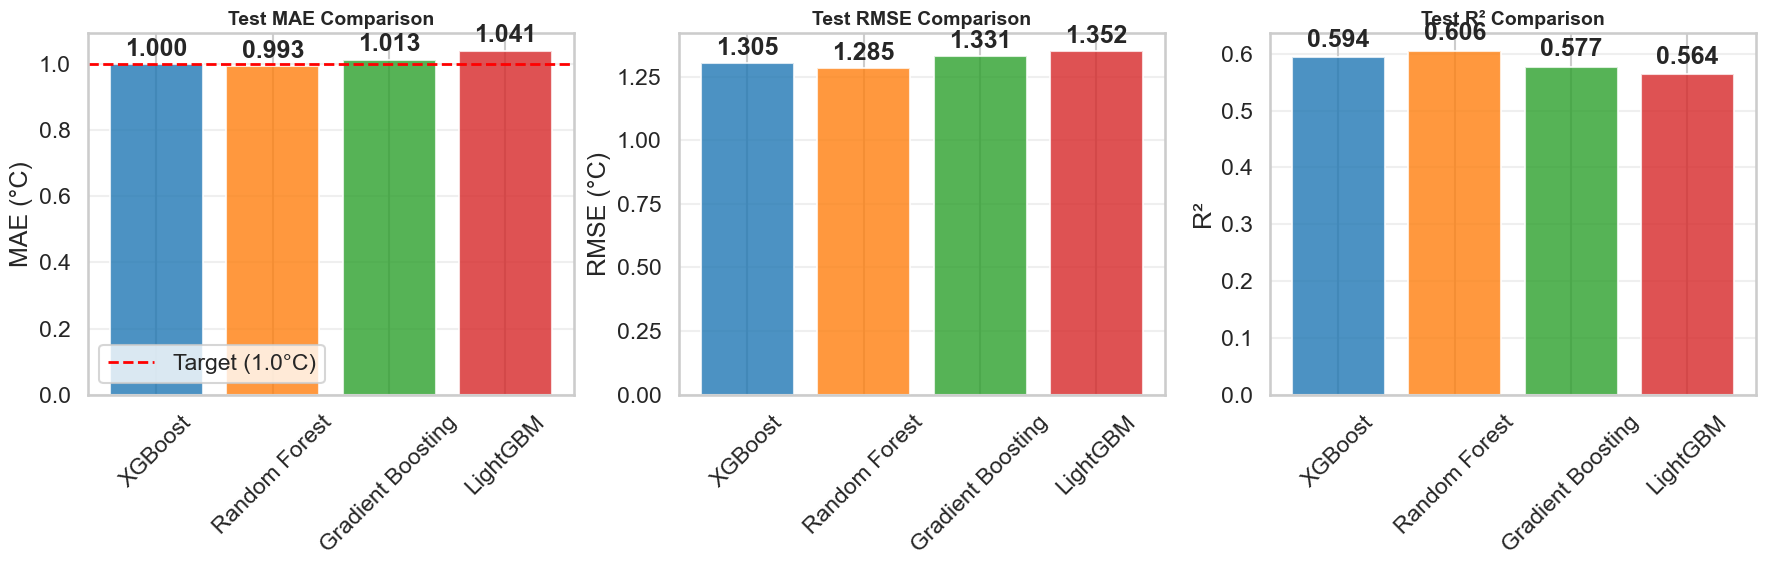

In [150]:
# Visualization of All Models Comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Extract data for plotting
models_list = results_comparison.index.tolist()
mae_values = results_comparison['Test MAE'].values
rmse_values = results_comparison['Test RMSE'].values
r2_values = results_comparison['Test R²'].values

# Color scheme
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']  # Blue, Orange, Green, Red

# 1. MAE Comparison
axes[0].bar(models_list, mae_values, color=colors, alpha=0.8)
axes[0].axhline(y=1.0, color='red', linestyle='--', linewidth=2, label='Target (1.0°C)')
axes[0].set_title('Test MAE Comparison', fontsize=14, fontweight='bold')
axes[0].set_ylabel('MAE (°C)')
axes[0].tick_params(axis='x', rotation=45)
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, v in enumerate(mae_values):
    axes[0].text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom', fontweight='bold')

# 2. RMSE Comparison
axes[1].bar(models_list, rmse_values, color=colors, alpha=0.8)
axes[1].set_title('Test RMSE Comparison', fontsize=14, fontweight='bold')
axes[1].set_ylabel('RMSE (°C)')
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, v in enumerate(rmse_values):
    axes[1].text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom', fontweight='bold')

# 3. R2 Comparison
axes[2].bar(models_list, r2_values, color=colors, alpha=0.8)
axes[2].set_title('Test R² Comparison', fontsize=14, fontweight='bold')
axes[2].set_ylabel('R²')
axes[2].tick_params(axis='x', rotation=45)
axes[2].grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, v in enumerate(r2_values):
    axes[2].text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()



# 9. Optimization Diagnostics

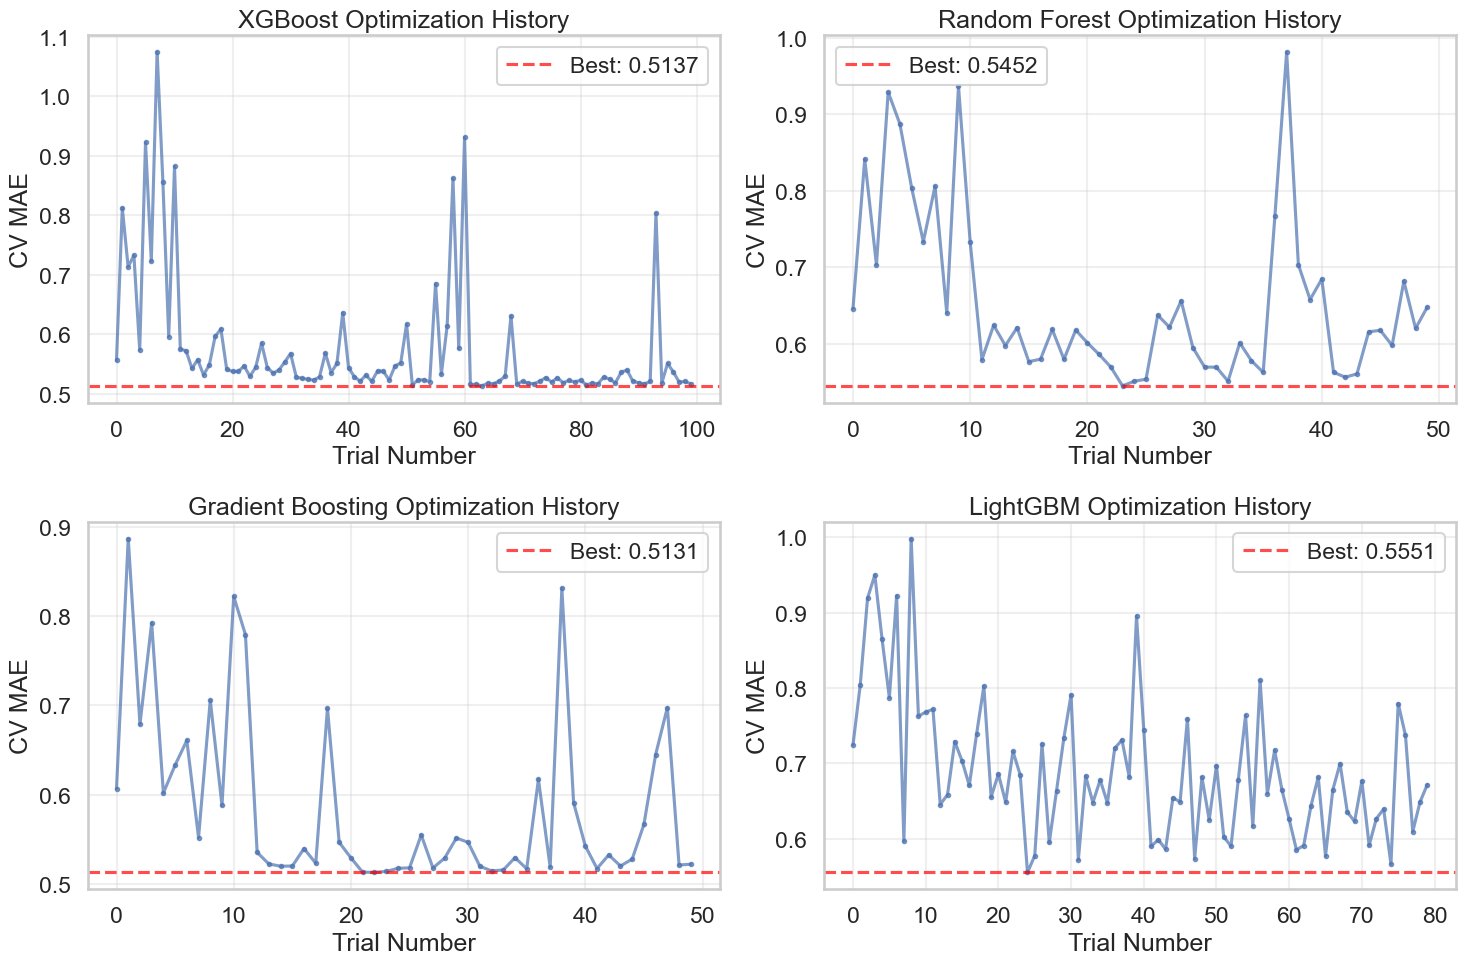

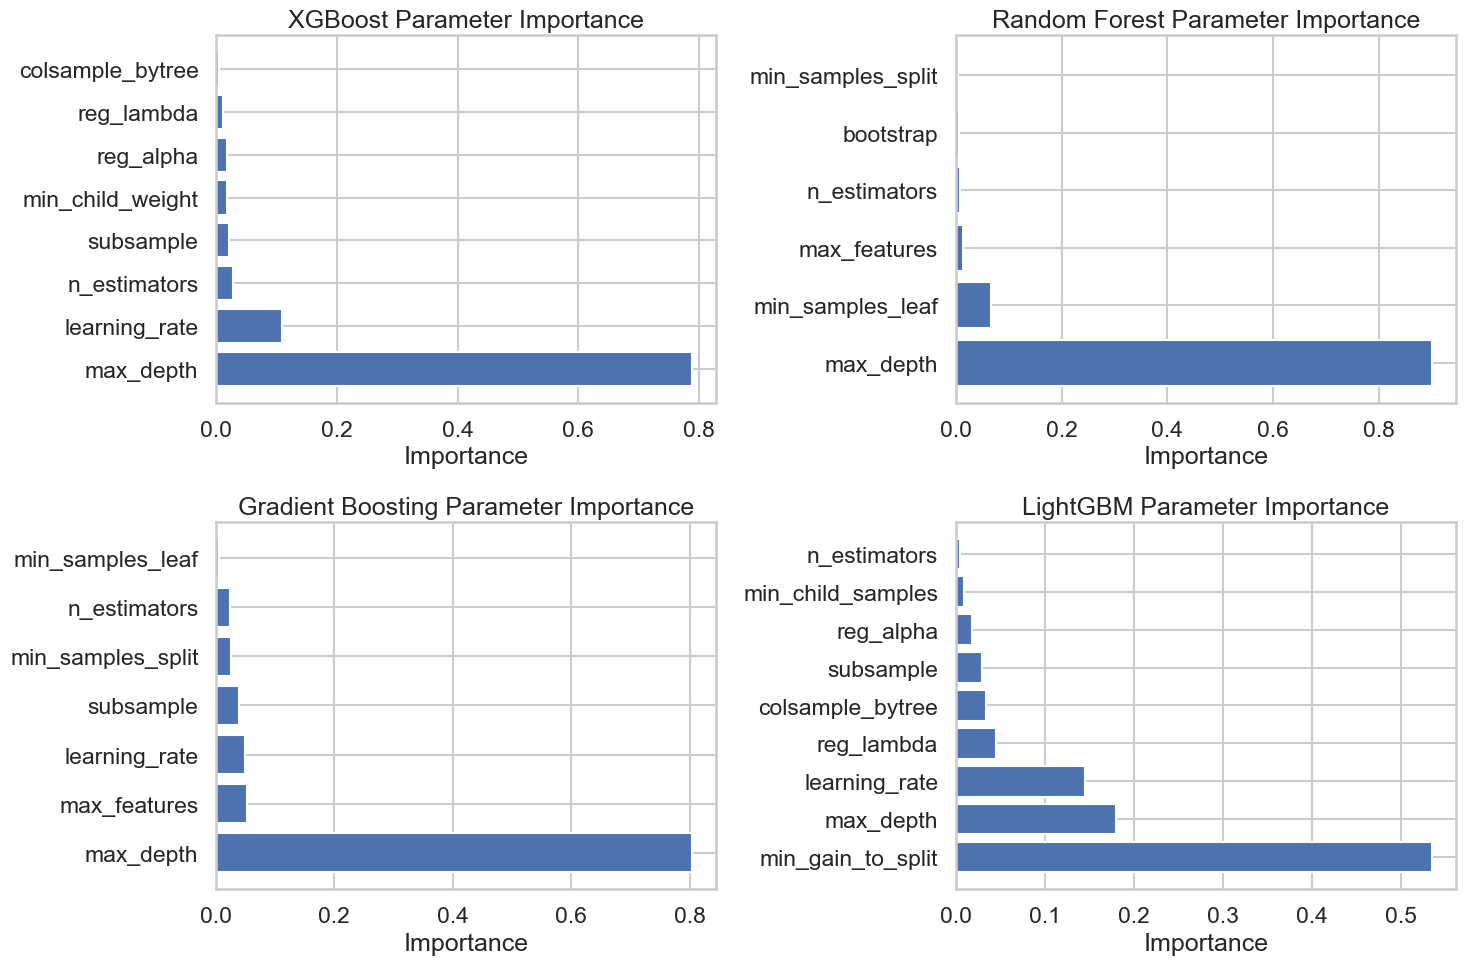

In [149]:
import optuna.visualization as vis

# Create optimization history plots
studies = {
    'XGBoost': xgb_study,
    'Random Forest': rf_study, 
    'Gradient Boosting': gb_study,
    'LightGBM': lgb_study
}

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()

for i, (name, study) in enumerate(studies.items()):
    # Optimization history
    trials = study.trials
    trial_numbers = [t.number for t in trials]
    values = [t.value for t in trials if t.value is not None]
    trial_nums = [t.number for t in trials if t.value is not None]
    
    axes[i].plot(trial_nums, values, 'o-', alpha=0.7, markersize=3)
    axes[i].axhline(y=study.best_value, color='red', linestyle='--', alpha=0.7, label=f'Best: {study.best_value:.4f}')
    axes[i].set_title(f'{name} Optimization History')
    axes[i].set_xlabel('Trial Number')
    axes[i].set_ylabel('CV MAE')
    axes[i].legend()
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Parameter importance plots
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()

for i, (name, study) in enumerate(studies.items()):
    try:
        importance = optuna.importance.get_param_importances(study)
        if importance:
            params = list(importance.keys())
            importances = list(importance.values())
            
            axes[i].barh(params, importances)
            axes[i].set_title(f'{name} Parameter Importance')
            axes[i].set_xlabel('Importance')
        else:
            axes[i].text(0.5, 0.5, 'No importance data', ha='center', va='center')
            axes[i].set_title(f'{name} Parameter Importance')
    except:
        axes[i].text(0.5, 0.5, 'Could not compute importance', ha='center', va='center')
        axes[i].set_title(f'{name} Parameter Importance')

plt.tight_layout()
plt.show()


# 10. Compare with Baseline

In [157]:
# Baseline results from 3_Modelling.ipynb
baseline_results = {
    'XGBoost FE+DT (Baseline)': {
        'test_mae': 1.0457,
        'test_rmse': 1.3546,
        'test_r2': 0.5620
    }
}

# Add optimized results for all models (using the final test results from cell 32)
optimized_results = {}
for model_name, result in all_test_results.items():
    optimized_results[f"{model_name} (Optimized)"] = {
        'test_mae': result['test_mae'],
        'test_rmse': result['test_rmse'],
        'test_r2': result['test_r2']
    }

# Combine results
comparison_df = pd.DataFrame({**baseline_results, **optimized_results}).T

print("Performance Comparison (Test Set):")
display(comparison_df.round(4))

Performance Comparison (Test Set):


,test_mae,test_rmse,test_r2
XGBoost FE+DT (Baseline),1.0457,1.3546,0.5620
XGBoost (Optimized),1.0000,1.3047,0.5937
Random Forest (Optimized),0.9934,1.2854,0.6056
Gradient Boosting (Optimized),1.0135,1.3310,0.5771
LightGBM (Optimized),1.0410,1.3522,0.5636


# 11. Visualization of Results

## 11.1 Metrics Comparision

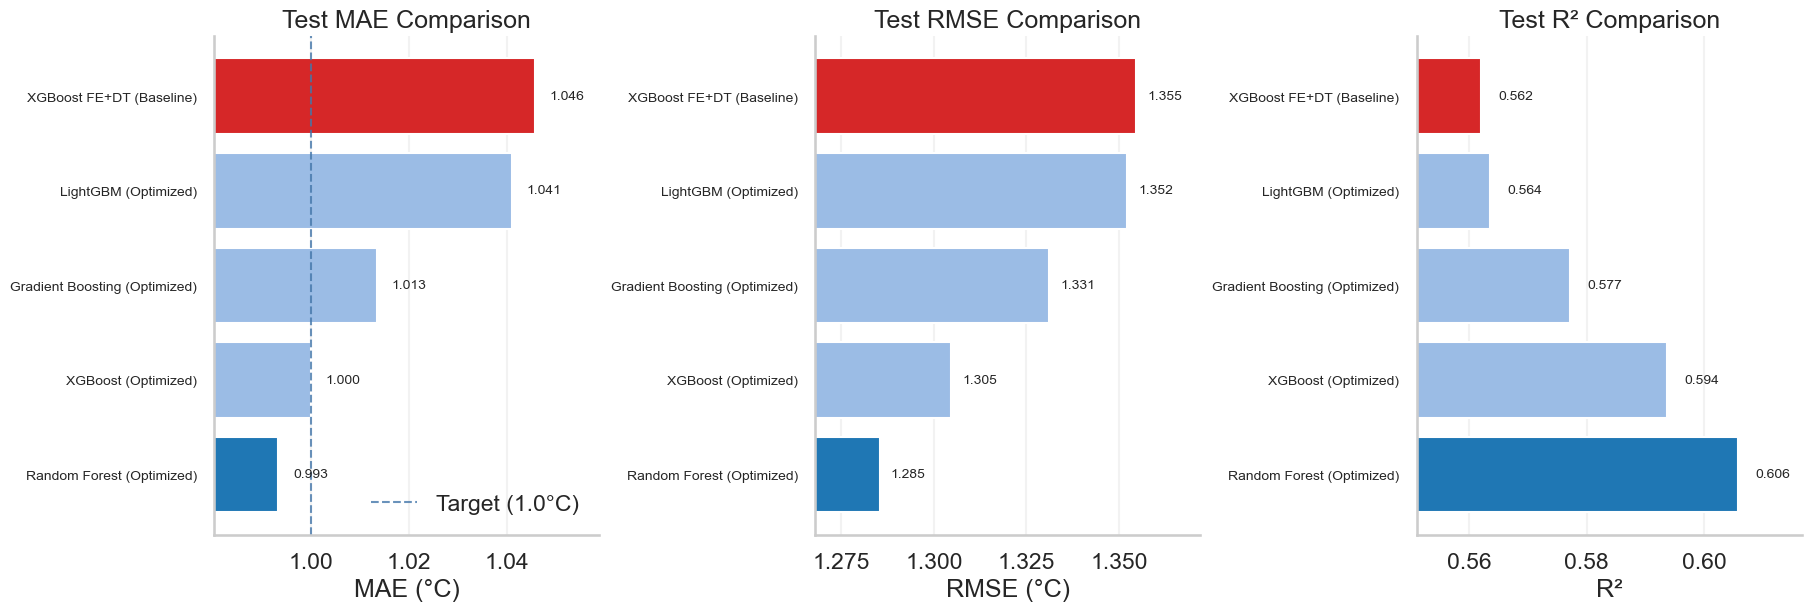

In [168]:
# Lấy dữ liệu từ comparison_df
models_list = comparison_df.index.tolist()
mae_values  = comparison_df['test_mae'].values
rmse_values = comparison_df['test_rmse'].values
r2_values   = comparison_df['test_r2'].values

# Hàm tô màu
def pick_colors(labels, best_idx):
    colors = []
    for i, m in enumerate(labels):
        if 'Baseline' in m:
            colors.append('#d62728')          # đỏ cho baseline
        elif i == best_idx:
            colors.append('#1f77b4')          # xanh đậm cho best
        else:
            colors.append('#9bbce5')          # xanh nhạt cho còn lại
    return colors

# Thứ tự hiển thị theo MAE tăng dần 
order = np.argsort(mae_values)
models_ord = [models_list[i] for i in order]
mae_ord    = mae_values[order]
rmse_ord   = rmse_values[order]
r2_ord     = r2_values[order]

# Vị trí tốt nhất trong từng metric
best_mae_pos  = int(np.argmin(mae_ord))
best_rmse_pos = int(np.argmin(rmse_ord))
best_r2_pos   = int(np.argmax(r2_ord))

# Hàm gắn nhãn giá trị lên cột 
def annotate_barh(ax, values, fmt="{:.3f}", dx=0.003):
    for rect, v in zip(ax.patches, values):
        x = rect.get_width()
        y = rect.get_y() + rect.get_height()/2
        ax.text(x + dx, y, fmt.format(v), va='center', fontsize=10)

# tạo 3 biểu đồ song song
fig, axes = plt.subplots(1, 3, figsize=(18, 6), constrained_layout=True)

# MAE 
colors_mae = pick_colors(models_ord, best_mae_pos)
axes[0].barh(models_ord, mae_ord, color=colors_mae)
axes[0].axvline(1.0, linestyle='--', linewidth=1.5, label='Target (1.0°C)', color='#4477aa', alpha=0.8)

m0, M0 = mae_ord.min(), mae_ord.max()
margin = max(0.01, (M0 - m0) * 0.25)
axes[0].set_xlim(m0 - margin, M0 + margin)
axes[0].set_xlabel('MAE (°C)')
axes[0].set_title('Test MAE Comparison')
axes[0].grid(False)                    # tắt toàn bộ grid
axes[0].grid(axis='x', alpha=0.25)     # bật lại grid dọc nhẹ
axes[0].legend(loc='lower right', frameon=False)
annotate_barh(axes[0], mae_ord)

# RMSE 
colors_rmse = pick_colors(models_ord, best_rmse_pos)
axes[1].barh(models_ord, rmse_ord, color=colors_rmse)

m1, M1 = rmse_ord.min(), rmse_ord.max()
margin = max(0.015, (M1 - m1) * 0.25)
axes[1].set_xlim(m1 - margin, M1 + margin)
axes[1].set_xlabel('RMSE (°C)')
axes[1].set_title('Test RMSE Comparison')
axes[1].grid(False)
axes[1].grid(axis='x', alpha=0.25)
annotate_barh(axes[1], rmse_ord)

# R² 
colors_r2 = pick_colors(models_ord, best_r2_pos)
axes[2].barh(models_ord, r2_ord, color=colors_r2)

m2, M2 = r2_ord.min(), r2_ord.max()
margin = max(0.003, (M2 - m2) * 0.25)
axes[2].set_xlim(m2 - margin, M2 + margin)
axes[2].set_xlabel('R²')
axes[2].set_title('Test R² Comparison')
axes[2].grid(False)
axes[2].grid(axis='x', alpha=0.25)
annotate_barh(axes[2], r2_ord)

# Làm gọn: bỏ khung thừa, căn nhãn
for ax in axes:
    ax.spines[['top','right']].set_visible(False)
    ax.tick_params(axis='y', labelsize=10)

plt.show()

## 11.2 Performance Monitoring Summary and Visualization

Performance Summary (clean):
           Operation        Group     Time (s)  Memory Peak (MB)  RSS Before (MB)  RSS After (MB)  RSS Delta (MB)
    XGB Optimization Optimization  3789.747958         25.981641       387.015625     1171.875000      784.859375
     RF Optimization Optimization  4168.456199         40.098789       265.015625     3108.750000     2843.734375
     GB Optimization Optimization 23840.210189         22.018584       392.359375      622.625000      230.265625
    LGB Optimization Optimization  3593.480472        112.320033      2932.890625     1262.015625    -1670.875000
Final Model Training        Final   131.787452         10.701883       593.671875      608.796875       15.125000
    Final Evaluation        Final     0.194771          1.134268       617.671875      620.343750        2.671875


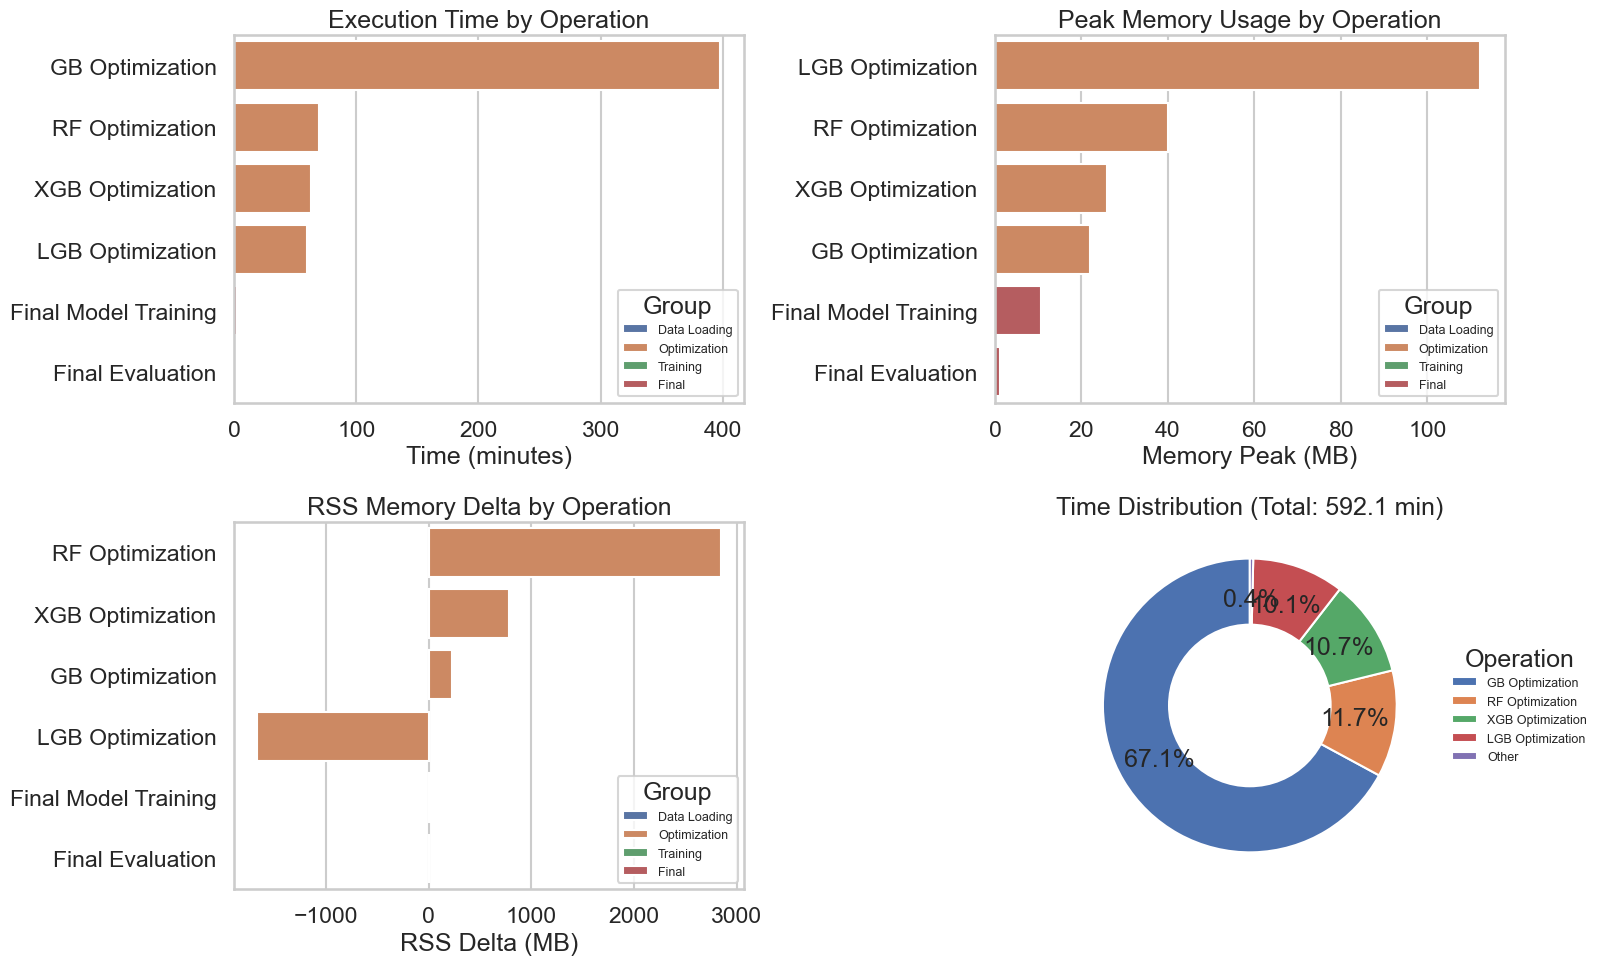

In [144]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from textwrap import wrap

def create_performance_summary():
    summary_data = []
    if 'data_loading' in performance_stats:
        for dataset, stats in performance_stats['data_loading'].items():
            summary_data.append({
                'Operation': f'Data Loading ({dataset})',
                'Group': 'Data Loading',
                'Time (s)': stats['seconds'],
                'Memory Peak (MB)': stats['py_peak_mb'],
                'RSS Before (MB)': stats.get('rss_before_mb', 'N/A'),
                'RSS After (MB)': stats.get('rss_after_mb', 'N/A'),
                'RSS Delta (MB)': stats.get('rss_delta_mb', 'N/A')
            })

    optimization_models = ['xgb_optimization', 'rf_optimization', 'gb_optimization', 'lgb_optimization']
    for model in optimization_models:
        if model in performance_stats:
            stats = performance_stats[model]
            model_name = model.replace('_optimization', '').upper()
            summary_data.append({
                'Operation': f'{model_name} Optimization',
                'Group': 'Optimization',
                'Time (s)': stats['seconds'],
                'Memory Peak (MB)': stats['py_peak_mb'],
                'RSS Before (MB)': stats.get('rss_before_mb', 'N/A'),
                'RSS After (MB)': stats.get('rss_after_mb', 'N/A'),
                'RSS Delta (MB)': stats.get('rss_delta_mb', 'N/A')
            })

    if 'model_training' in performance_stats:
        for model, stats in performance_stats['model_training'].items():
            model_name = model.upper()
            summary_data.append({
                'Operation': f'{model_name} Training',
                'Group': 'Training',
                'Time (s)': stats['seconds'],
                'Memory Peak (MB)': stats['py_peak_mb'],
                'RSS Before (MB)': stats.get('rss_before_mb', 'N/A'),
                'RSS After (MB)': stats.get('rss_after_mb', 'N/A'),
                'RSS Delta (MB)': stats.get('rss_delta_mb', 'N/A')
            })

    if 'final_model_training' in performance_stats:
        stats = performance_stats['final_model_training']
        summary_data.append({
            'Operation': 'Final Model Training',
            'Group': 'Final',
            'Time (s)': stats['seconds'],
            'Memory Peak (MB)': stats['py_peak_mb'],
            'RSS Before (MB)': stats.get('rss_before_mb', 'N/A'),
            'RSS After (MB)': stats.get('rss_after_mb', 'N/A'),
            'RSS Delta (MB)': stats.get('rss_delta_mb', 'N/A')
        })

    if 'final_evaluation' in performance_stats:
        stats = performance_stats['final_evaluation']
        summary_data.append({
            'Operation': 'Final Evaluation',
            'Group': 'Final',
            'Time (s)': stats['seconds'],
            'Memory Peak (MB)': stats['py_peak_mb'],
            'RSS Before (MB)': stats.get('rss_before_mb', 'N/A'),
            'RSS After (MB)': stats.get('rss_after_mb', 'N/A'),
            'RSS Delta (MB)': stats.get('rss_delta_mb', 'N/A')
        })

    df = pd.DataFrame(summary_data)

    for col in ['Time (s)', 'Memory Peak (MB)', 'RSS Before (MB)', 'RSS After (MB)', 'RSS Delta (MB)']:
        df[col] = pd.to_numeric(df[col], errors='coerce')

    # Nhóm thứ tự hợp lý
    cat_order = ['Data Loading', 'Optimization', 'Training', 'Final']
    df['Group'] = pd.Categorical(df['Group'], categories=cat_order, ordered=True)

    # Làm gọn nhãn quá dài cho đẹp
    df['Operation'] = df['Operation'].apply(lambda s: '\n'.join(wrap(str(s), width=28)))

    return df

perf_summary = create_performance_summary()
print("Performance Summary (clean):")
print(perf_summary.to_string(index=False))

# Sau khi đã có perf_summary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style='whitegrid', context='talk')

# ---- Chuẩn hóa: Seconds -> Minutes
perf_summary = perf_summary.copy()
perf_summary['Time (min)'] = perf_summary['Time (s)'] / 60.0

# Dữ liệu cho từng biểu đồ
time_df = perf_summary.dropna(subset=['Time (min)']).copy()
time_df = time_df.sort_values(['Group', 'Time (min)'], ascending=[True, False])

mem_df = perf_summary.dropna(subset=['Memory Peak (MB)']).copy()
mem_df = mem_df.sort_values(['Group', 'Memory Peak (MB)'], ascending=[True, False])

rss_df = perf_summary.dropna(subset=['RSS Delta (MB)']).copy()
if not rss_df.empty:
    rss_df = rss_df.sort_values(['Group', 'RSS Delta (MB)'], ascending=[True, False])

# ---- 4 subplot
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# (1) Execution Time (minutes)
ax = axes[0, 0]
sns.barplot(
    data=time_df,
    y='Operation', x='Time (min)',
    hue='Group', dodge=False, ax=ax
)
ax.set_title('Execution Time by Operation')
ax.set_xlabel('Time (minutes)')
ax.set_ylabel('')
ax.legend(title='Group', loc='lower right', fontsize=9)

# (2) Peak Memory
ax = axes[0, 1]
sns.barplot(
    data=mem_df,
    y='Operation', x='Memory Peak (MB)',
    hue='Group', dodge=False, ax=ax
)
ax.set_title('Peak Memory Usage by Operation')
ax.set_xlabel('Memory Peak (MB)')
ax.set_ylabel('')
ax.legend(title='Group', loc='lower right', fontsize=9)

# (3) RSS Delta (nếu có)
ax = axes[1, 0]
if not rss_df.empty:
    sns.barplot(
        data=rss_df,
        y='Operation', x='RSS Delta (MB)',
        hue='Group', dodge=False, ax=ax
    )
    ax.set_title('RSS Memory Delta by Operation')
    ax.set_xlabel('RSS Delta (MB)')
    ax.set_ylabel('')
    ax.legend(title='Group', loc='lower right', fontsize=9)
else:
    ax.axis('off')
    ax.text(0.5, 0.5, 'RSS Delta data not available', ha='center', va='center', fontsize=12)

# (4) Donut chart: Time Distribution (minutes)
ax = axes[1, 1]
t = time_df[['Operation', 'Time (min)']].groupby('Operation', as_index=False).sum()
t = t.sort_values('Time (min)', ascending=False)

# gom nhóm phần rất nhỏ thành "Other" để tránh rối nhãn
total_min = t['Time (min)'].sum()
t['pct'] = t['Time (min)'] / total_min
big = t[t['pct'] >= 0.03].copy()
small = t[t['pct'] < 0.03].copy()
if not small.empty:
    other_min = small['Time (min)'].sum()
    big = pd.concat([big[['Operation','Time (min)']], 
                     pd.DataFrame({'Operation':['Other'], 'Time (min)':[other_min]})],
                    ignore_index=True)
else:
    big = big[['Operation','Time (min)']]

wedges, texts, autotexts = ax.pie(
    big['Time (min)'].values,
    labels=None,
    autopct='%1.1f%%',
    startangle=90,
    pctdistance=0.72
)
# donut hole
centre_circle = plt.Circle((0, 0), 0.55, fc='white')
ax.add_artist(centre_circle)
ax.set_title(f'Time Distribution (Total: {total_min:.1f} min)')
# legend gọn, đặt ngoài
ax.legend(
    wedges,
    big['Operation'].tolist(),
    title="Operation",
    loc="center left",
    bbox_to_anchor=(1.02, 0.5),
    frameon=False,
    fontsize=9
)

plt.tight_layout()
plt.show()


# 12. Save Optimized Random Forest Model

In [ ]:
import joblib
import os
from datetime import datetime

# Create models directory if it doesn't exist
models_dir = '../models'
os.makedirs(models_dir, exist_ok=True)

# Get the best Random Forest model
best_rf_model = final_models['Random Forest']

# Save the model with timestamp
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
model_filename = f"rf_optimized_{timestamp}.joblib"
model_path = os.path.join(models_dir, model_filename)

# Save the model
joblib.dump(best_rf_model, model_path)
print(f"Random Forest model saved to: {model_path}")

# Also save model metadata
metadata = {
    'model_type': 'RandomForestRegressor',
    'optimization_method': 'Optuna',
    'best_params': rf_study.best_params,
    'cv_mae': rf_study.best_value,
    'test_mae': all_test_results['Random Forest']['test_mae'],
    'test_rmse': all_test_results['Random Forest']['test_rmse'],
    'test_r2': all_test_results['Random Forest']['test_r2'],
    'features': list(X_train.columns),
    'training_samples': len(X_train_val),
    'test_samples': len(X_test),
    'created_at': timestamp,
    'seed': SEED
}

# Save metadata
metadata_filename = f"rf_optimized_metadata_{timestamp}.json"
metadata_path = os.path.join(models_dir, metadata_filename)

import json
with open(metadata_path, 'w') as f:
    json.dump(metadata, f, indent=2)

print(f"Model metadata saved to: {metadata_path}")

# Display model summary
print(f"\nModel Summary:")
print(f"  Model Type: Random Forest Regressor")
print(f"  Best CV MAE: {rf_study.best_value:.4f}°C")
print(f"  Test MAE: {all_test_results['Random Forest']['test_mae']:.4f}°C")
print(f"  Test RMSE: {all_test_results['Random Forest']['test_rmse']:.4f}°C")
print(f"  Test R²: {all_test_results['Random Forest']['test_r2']:.4f}")
print(f"  Features: {len(X_train.columns)}")
print(f"  Training samples: {len(X_train_val)}")
print(f"  Test samples: {len(X_test)}")

print(f"\nBest Parameters:")
for param, value in rf_study.best_params.items():
    print(f"  {param}: {value}")


SAVING OPTIMIZED RANDOM FOREST MODEL
Random Forest model saved to: ../models/rf_optimized_20251027_173819.joblib
Model metadata saved to: ../models/rf_optimized_metadata_20251027_173819.json

Model Summary:
  Model Type: Random Forest Regressor
  Best CV MAE: 0.5452°C
  Test MAE: 0.9934°C
  Test RMSE: 1.2854°C
  Test R²: 0.6056
  Features: 23
  Training samples: 62208
  Test samples: 6444

Best Parameters:
  n_estimators: 1324
  max_depth: 24
  min_samples_split: 4
  min_samples_leaf: 1
  max_features: 0.5
  bootstrap: False
